Hello Ryan!

I’m happy to review your project today.
I will mark your mistakes and give you some hints how it is possible to fix them. We are getting ready for real job, where your team leader/senior colleague will do exactly the same. Don't worry and study with pleasure!

Below you will find my comments - **please do not move, modify or delete them**.

You can find my comments in green, yellow or red boxes like this:

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Success. Everything is done succesfully.
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Remarks. Some recommendations.
</div>

<div class="alert alert-block alert-danger">

<b>Reviewer's comment</b> <a class="tocSkip"></a>

Needs fixing. The block requires some corrections. Work can't be accepted with the red comments.
</div>

You can answer me by using this:

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Text here.
</div>


# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import re

from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from lightgbm import LGBMClassifier


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## EDA

Let's check the number of movies and reviews over years.

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.dtypes

tconst              object
title_type          object
primary_title       object
original_title      object
start_year           int64
end_year            object
runtime_minutes     object
is_adult             int64
genres              object
average_rating     float64
votes                Int64
review              object
rating               int64
sp                  object
pos                  int64
ds_part             object
idx                  int64
dtype: object

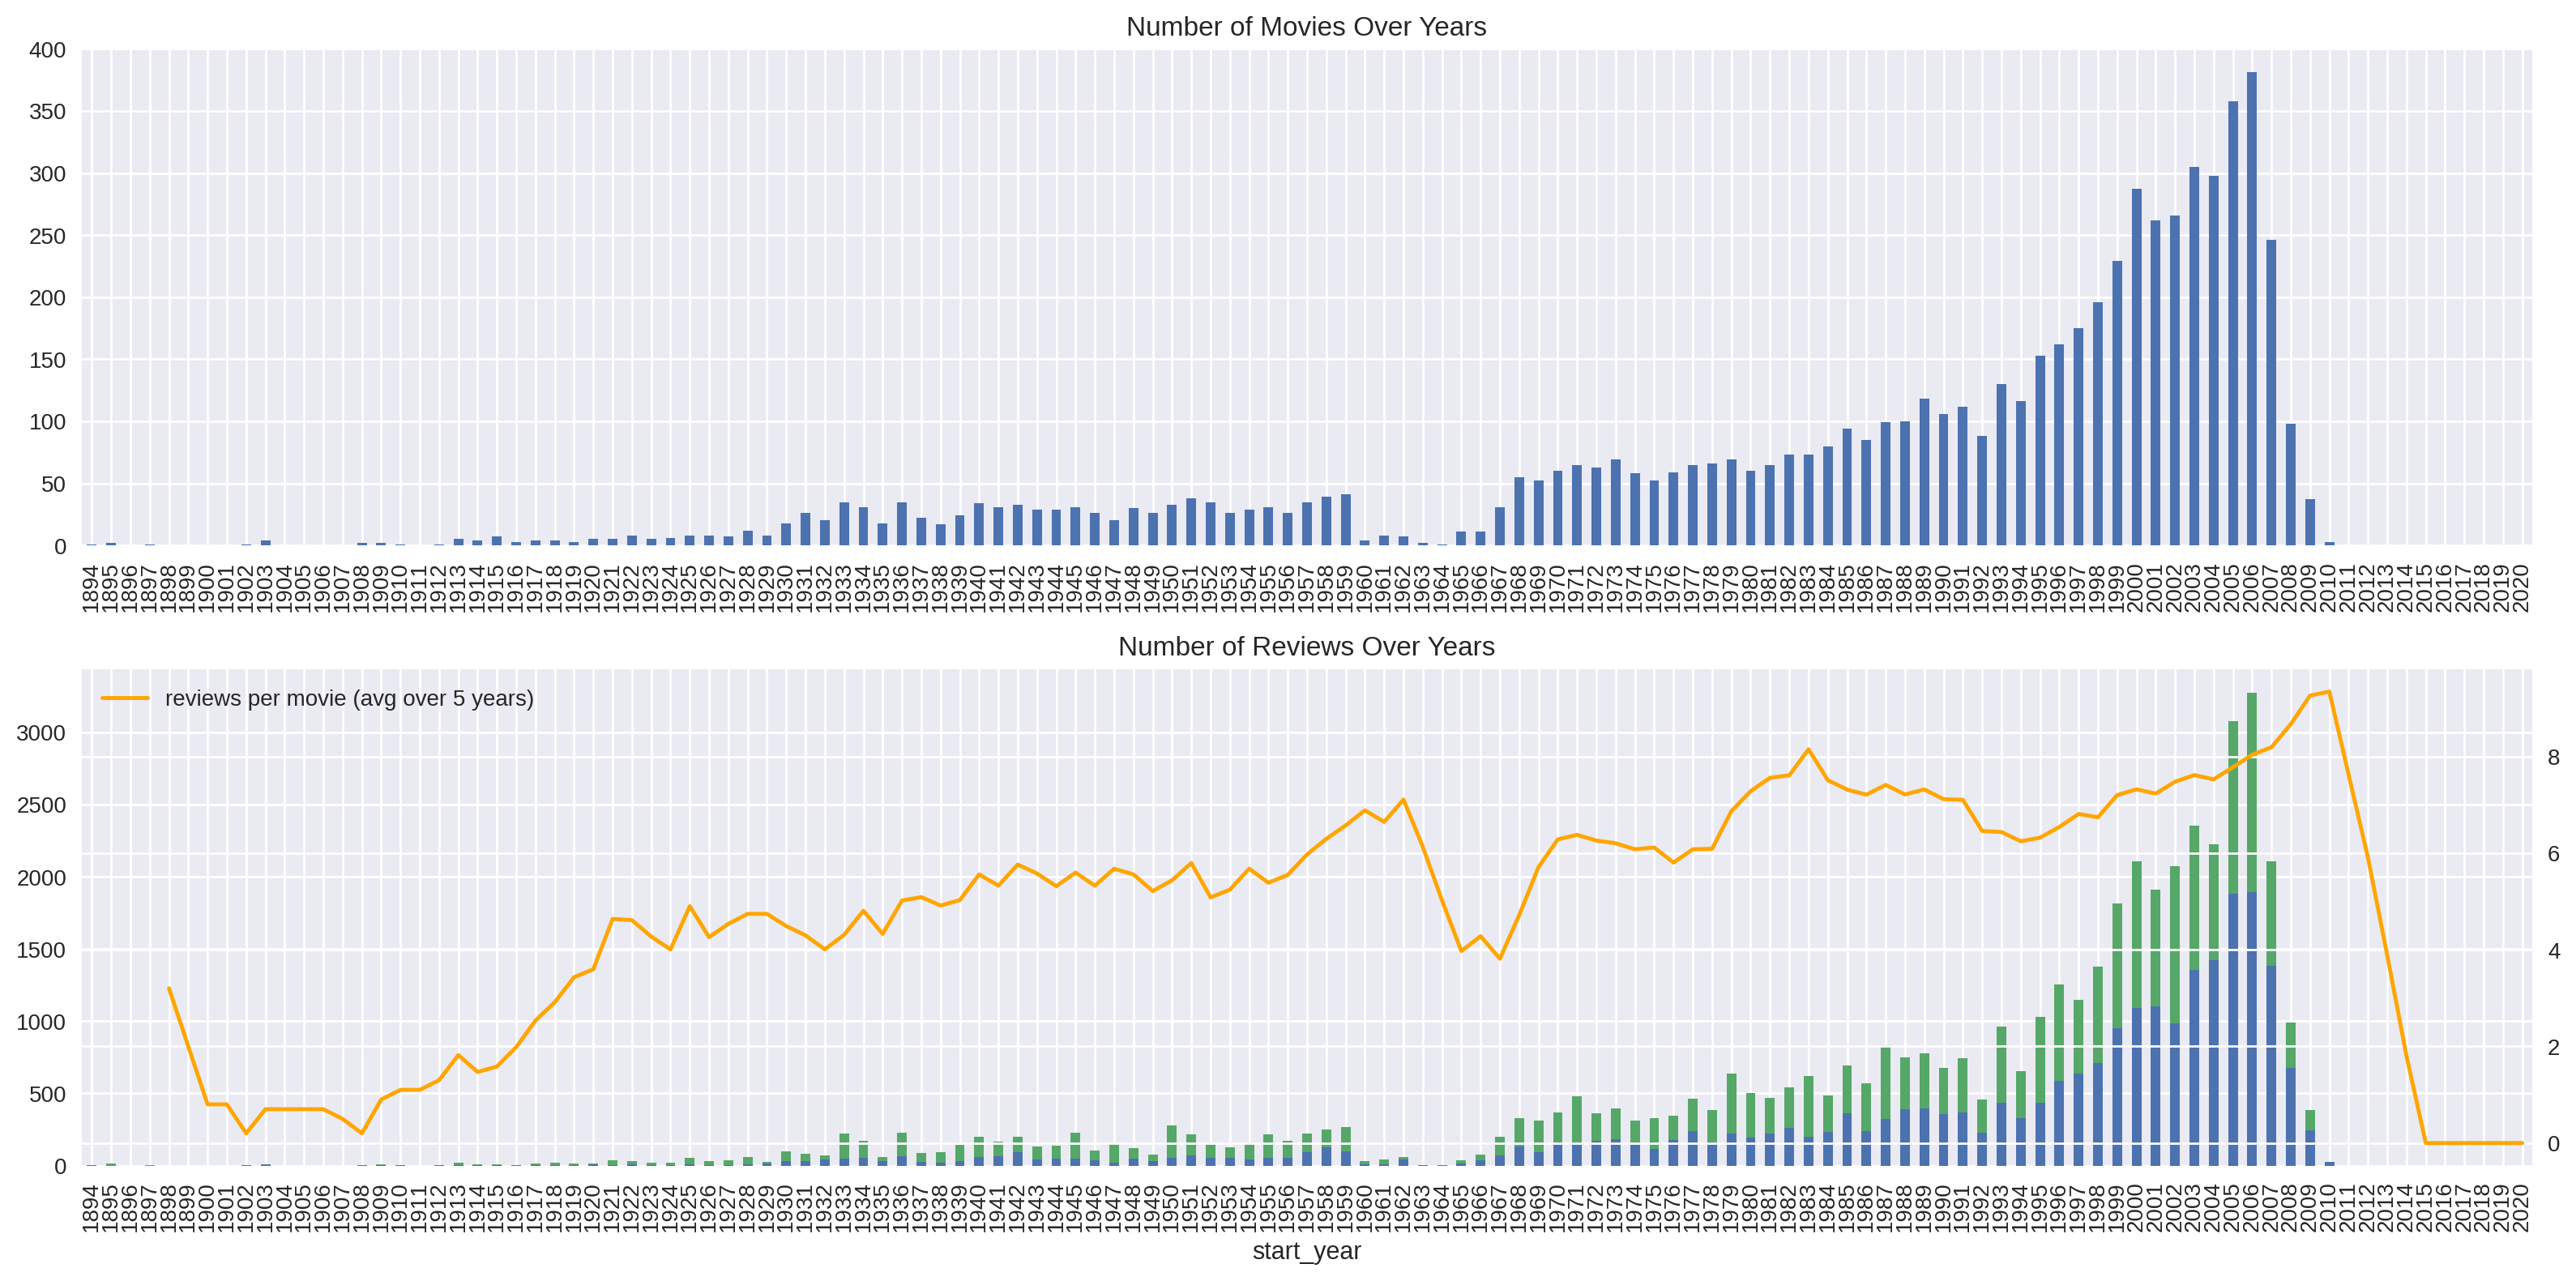

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

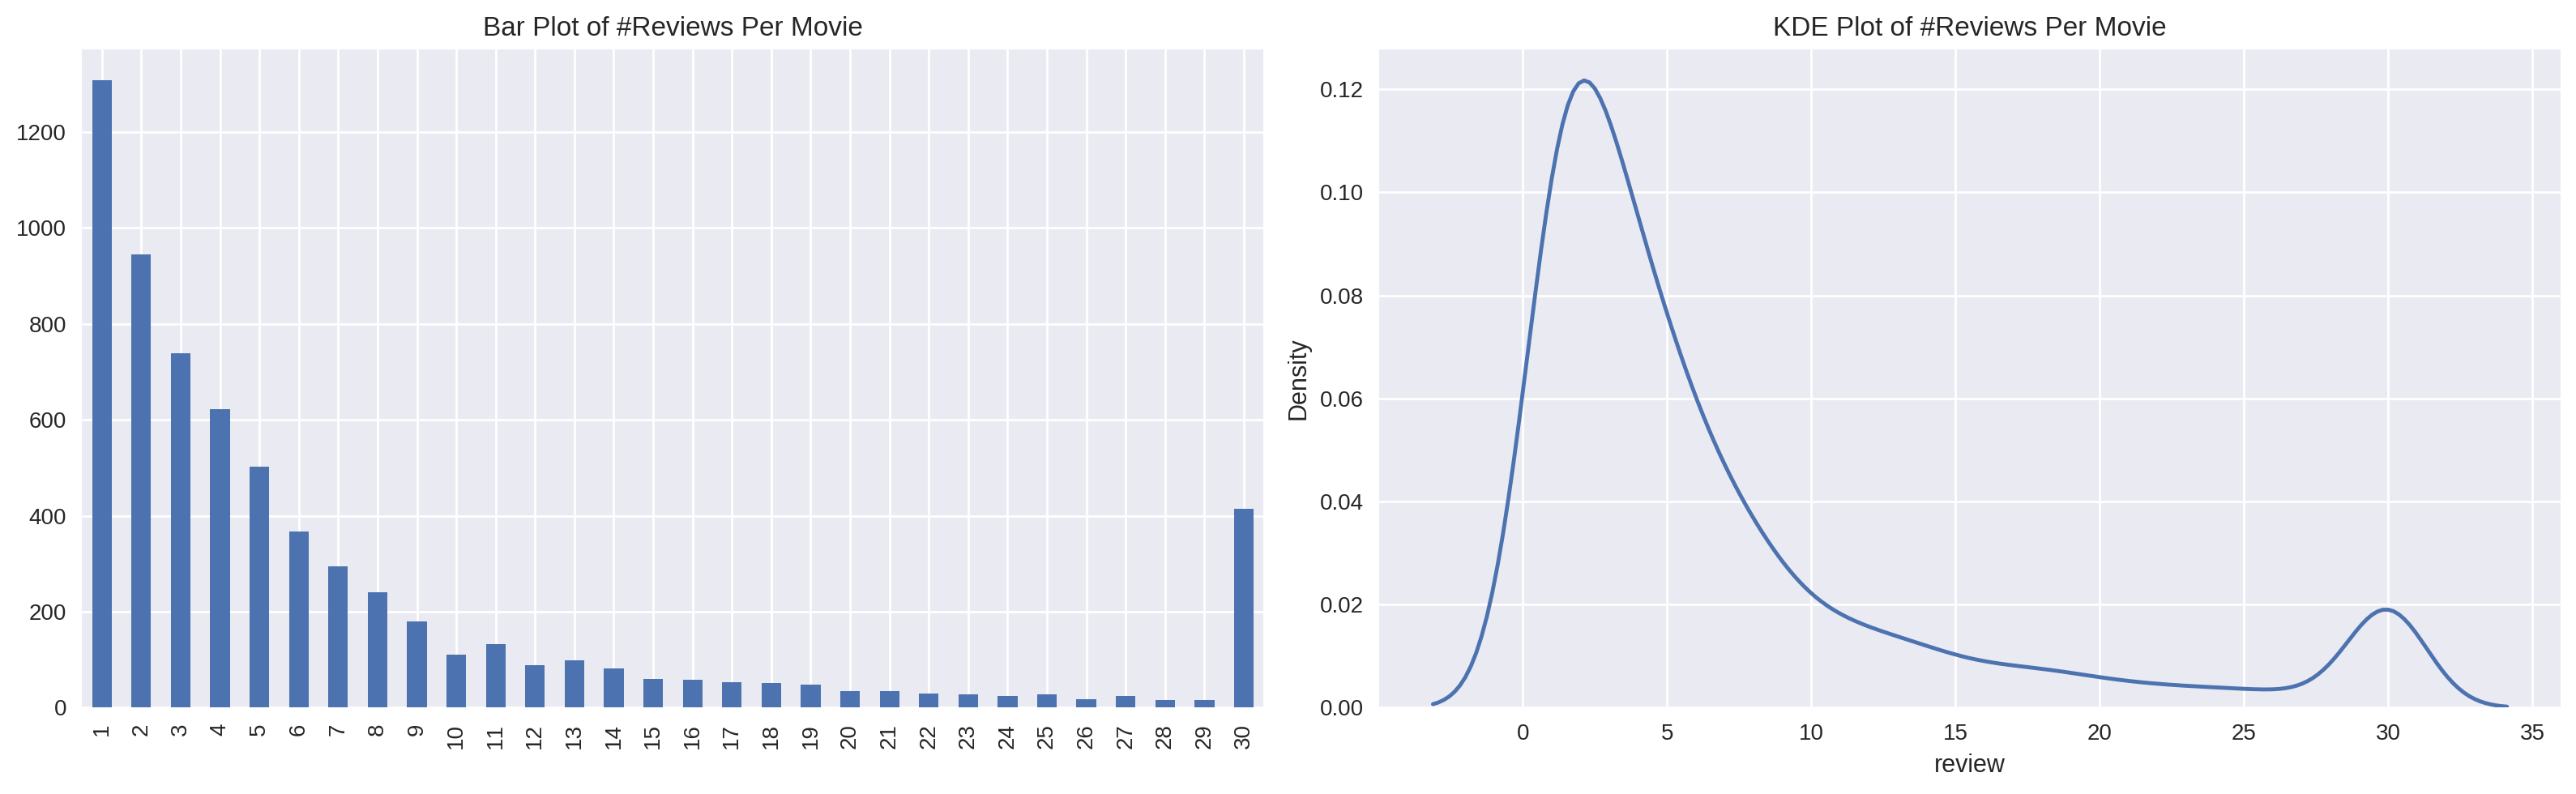

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [9]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

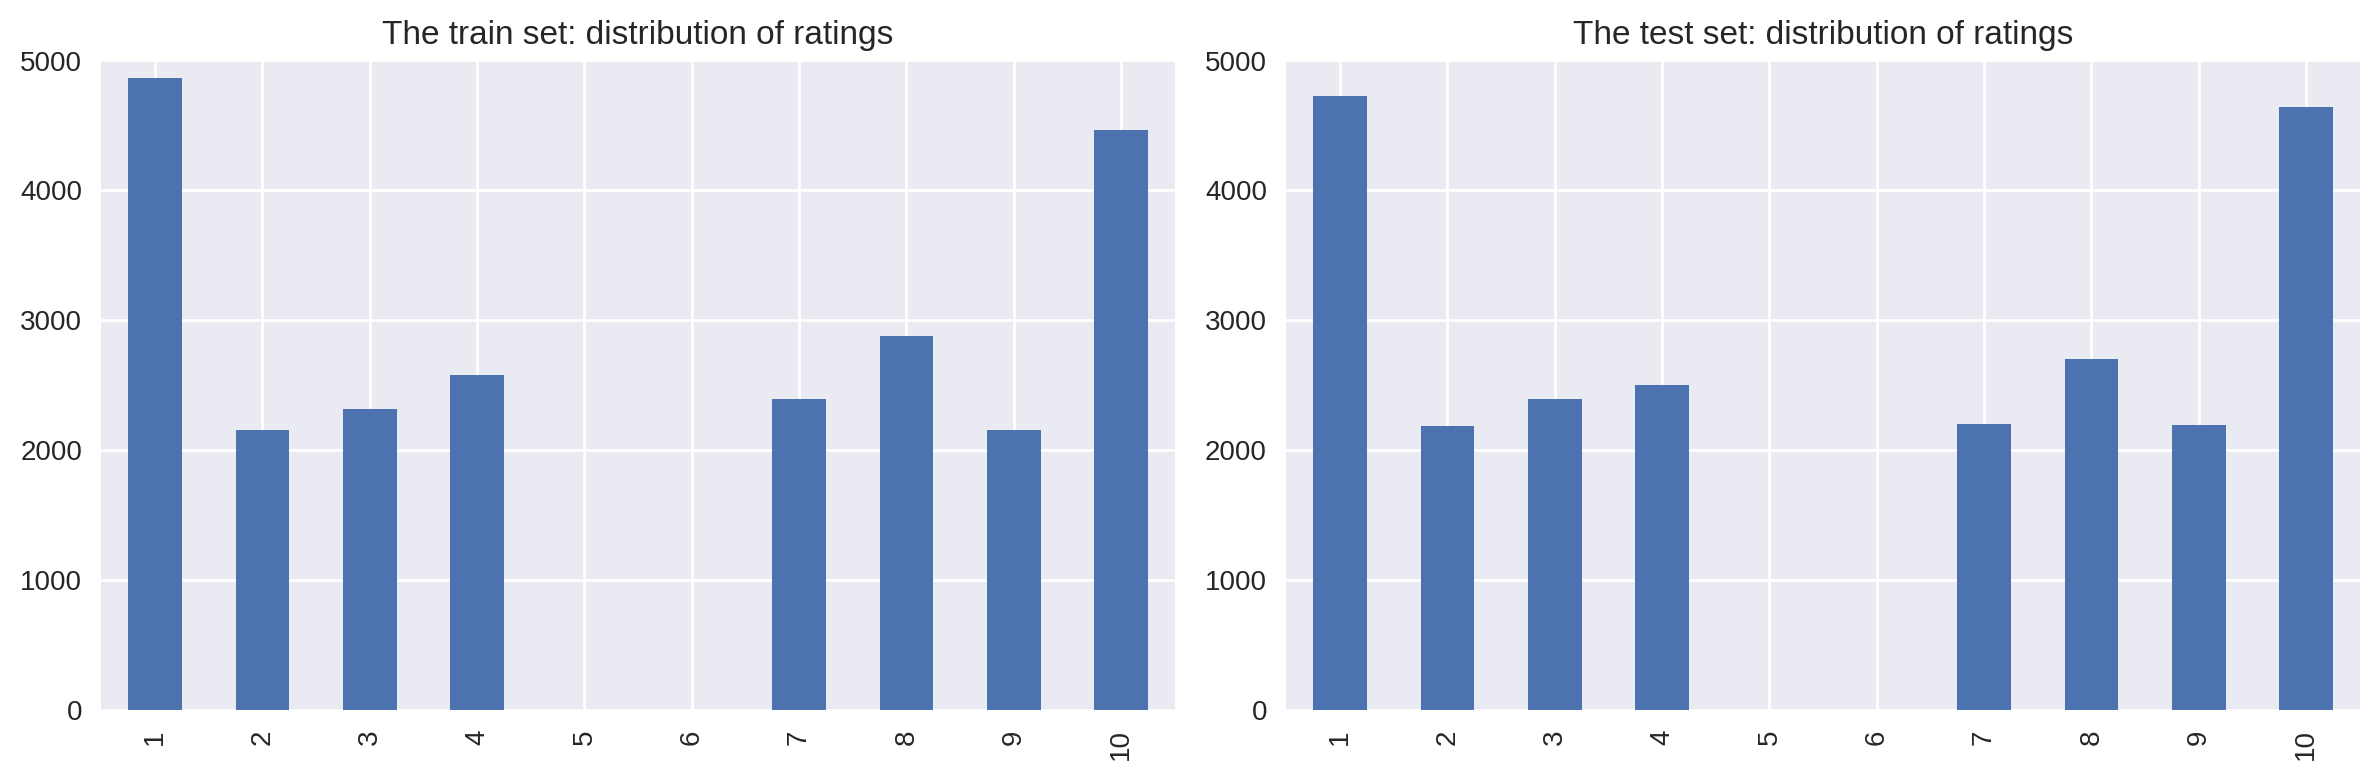

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


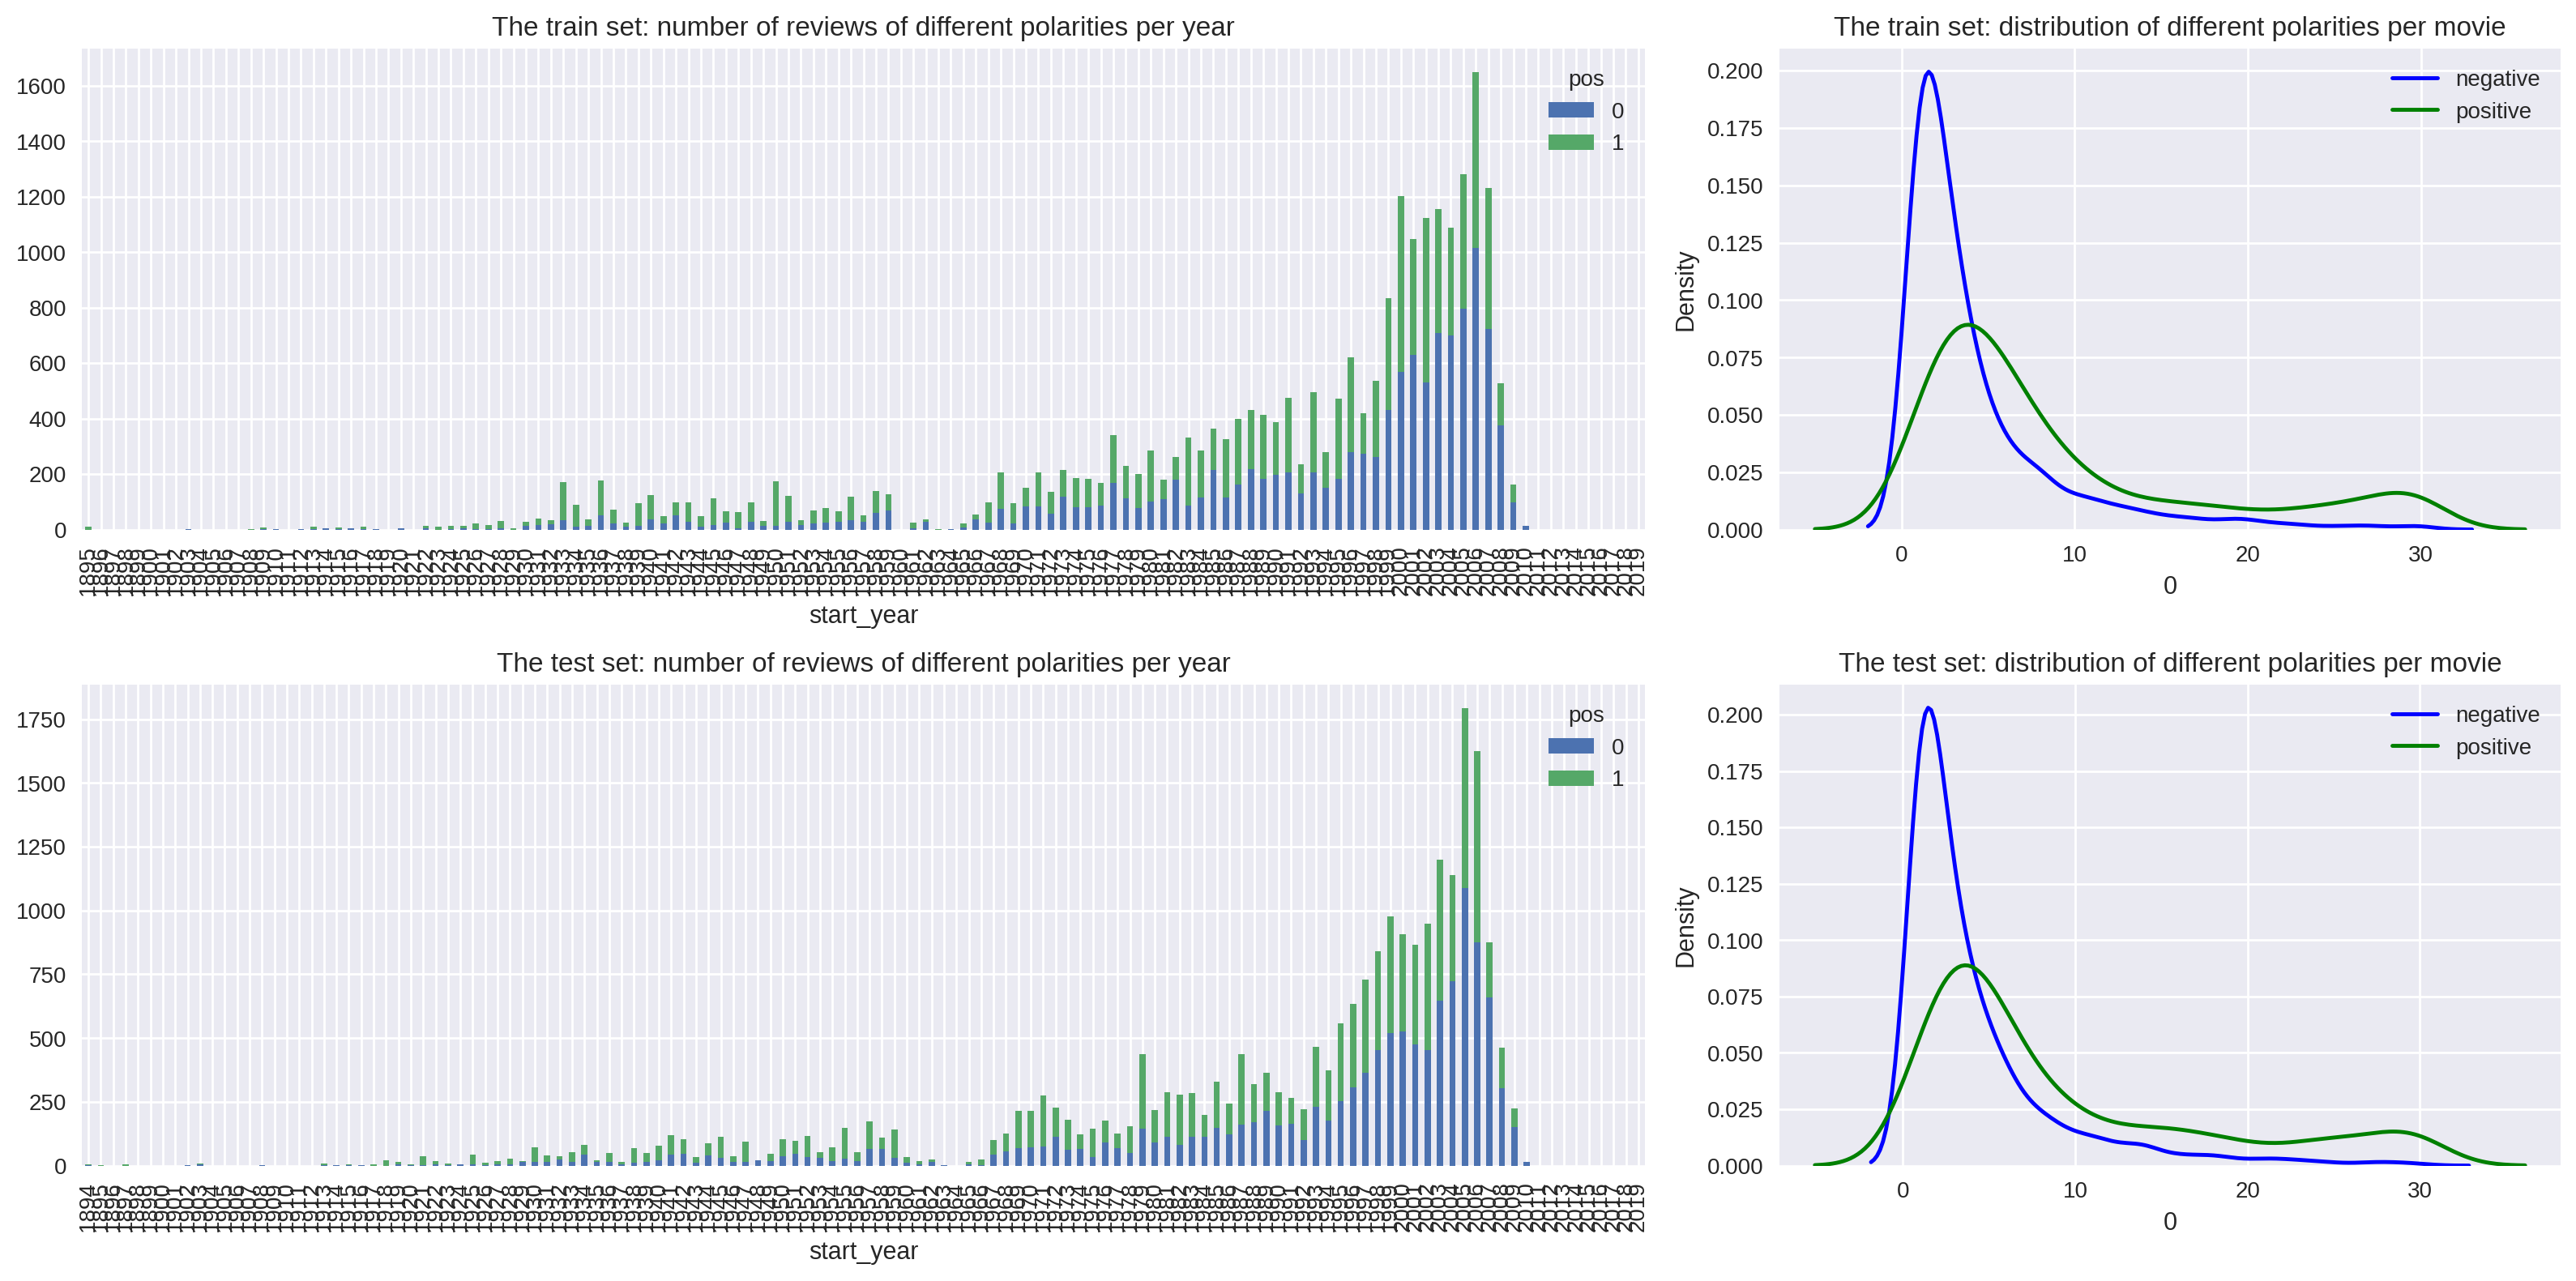

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

<div class="alert alert-warning">
<b>Reviewer's comment V1</b>

All the graphs are drawn for you. But you need to draw a conclusion based on them.

</div>

In [12]:
# Check for missing values
missing_values = df_reviews.isnull().sum()

# Check class distribution
class_distribution = df_reviews["pos"].value_counts(normalize=True)

missing_values, class_distribution

(tconst             0
 title_type         0
 primary_title      0
 original_title     0
 start_year         0
 end_year           0
 runtime_minutes    0
 is_adult           0
 genres             0
 average_rating     2
 votes              2
 review             0
 rating             0
 sp                 0
 pos                0
 ds_part            0
 idx                0
 dtype: int64,
 0    0.501046
 1    0.498954
 Name: pos, dtype: float64)

No Missing Values in "review" or "pos": The review and pos columns are complete, so no need for imputation. The class distribution is approximately 50.1% negative and 49.9% positive, meaning there is no significant class imbalance.

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Correct

</div>

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Preprocessing before modeling

In [14]:
# Select only relevant columns
df_reviews = df_reviews[["review", "pos", "ds_part"]]

# Check the updated structure of the dataset
df_reviews.head()

,review,pos,ds_part
0,The pakage implies that Warren Beatty and Gold...,0,train
1,How the hell did they get this made?! Presenti...,0,train
2,There is no real story the film seems more lik...,0,test
3,Um .... a serious film about troubled teens in...,1,test
4,I'm totally agree with GarryJohal from Singapo...,1,test


I've preprocessed the data by selecting only the relevant columns (review, pos, and ds_part) and preparing it for modeling (e.g., text vectorization).

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [15]:
# Function to normalize text
def normalize_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply normalization to reviews
df_reviews["review_norm"] = df_reviews["review"].apply(normalize_text)

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Good job!

</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [16]:
# Separate train and test data
train_df = df_reviews[df_reviews["ds_part"] == "train"].drop(columns=["ds_part"])
test_df = df_reviews[df_reviews["ds_part"] == "test"].drop(columns=["ds_part"])

# Extract features and labels
X_train, y_train = train_df["review"], train_df["pos"]
X_test, y_test = test_df["review"], test_df["pos"]

# Apply TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words="english", max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Check shape of transformed data
X_train_tfidf.shape, X_test_tfidf.shape

((23796, 10000), (23535, 10000))

## Working with models

### Model 0 - Constant

In [17]:
from sklearn.dummy import DummyClassifier

In [18]:
# Initialize a Dummy Classifier that always predicts the most frequent class
dummy_clf = DummyClassifier(strategy="stratified")

# Train the Dummy Classifier
dummy_clf.fit(X_train_tfidf, y_train)

# Predict using the Dummy Classifier
y_pred_dummy = dummy_clf.predict(X_test_tfidf)

# Evaluate Dummy Model
f1_dummy = f1_score(y_test, y_pred_dummy)

# Display F1 score
print(f"Dummy Classifier (Constant) F1 Score: {f1_dummy:.4f}")

Dummy Classifier (Constant) F1 Score: 0.4955


The stratified Dummy Classifier gives a fairer baseline because it predicts both classes randomly in proportion to the dataset. 

<div class="alert alert-warning">
<b>Reviewer's comment V1</b>

Correct. But "that always predicts the most frequent class" is not true. To predict "most frequent class" you need to use another value for the parameter `strategy`.

</div>

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [19]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [20]:
stop_words = set(stopwords.words("english"))

In [21]:
# TF-IDF Vectorization with NLTK Stopwords
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words, max_features=10000)
train_features_1 = tfidf_vectorizer_1.fit_transform(X_train)
test_features_1 = tfidf_vectorizer_1.transform(X_test)

In [22]:
# Train Logistic Regression Model
model_1 = LogisticRegression(max_iter=500)
model_1.fit(train_features_1, y_train)

LogisticRegression(max_iter=500)

In [23]:
# Predictions
y_pred_model_1 = model_1.predict(test_features_1)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


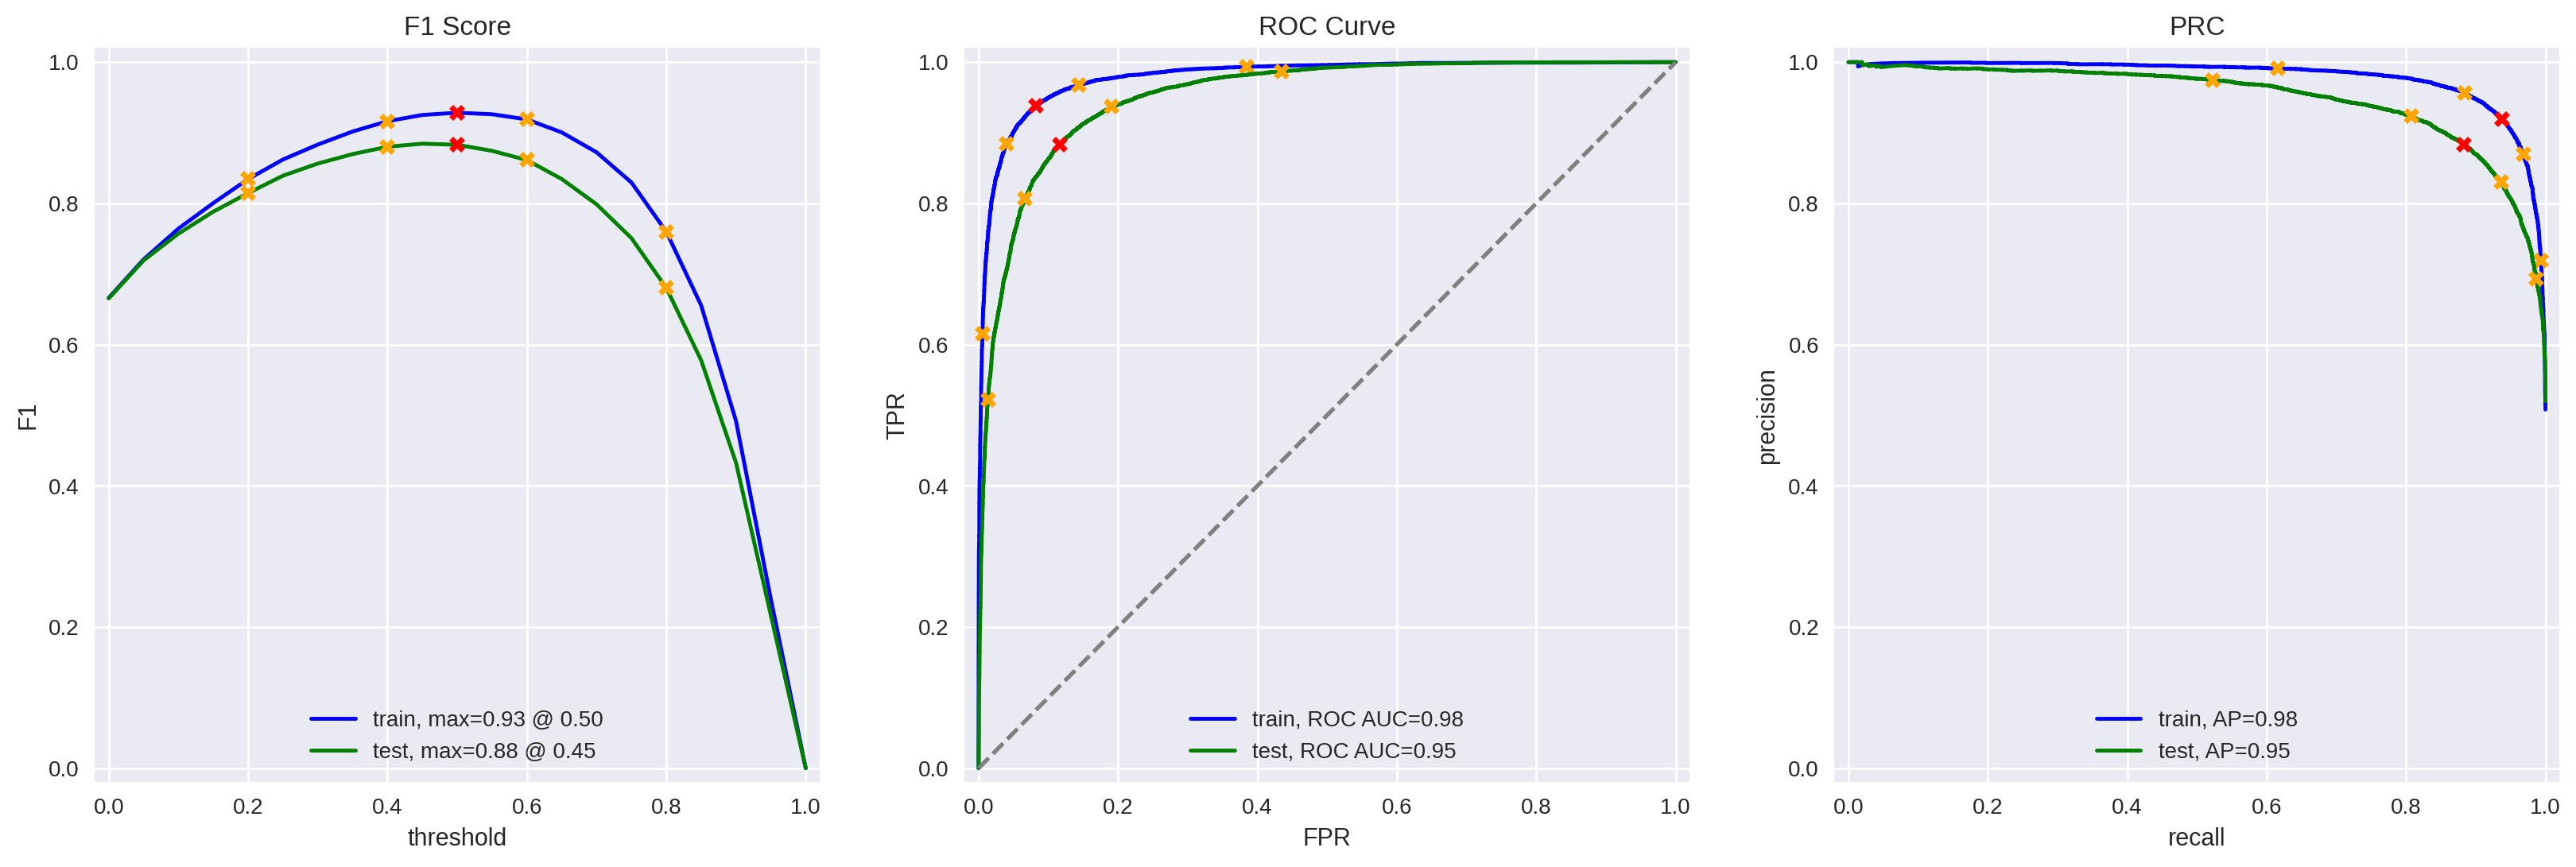

In [24]:
evaluate_model(model_1, train_features_1, y_train, test_features_1, y_test)

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Well done!

</div>

### Model 2 - spaCy, TF-IDF and LGBMClassifier

In [25]:
# TF-IDF Vectorization with NLTK Stopwords
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words, max_features=10000)
train_features_2 = tfidf_vectorizer_2.fit_transform(X_train)
test_features_2 = tfidf_vectorizer_2.transform(X_test)

In [26]:
# Train LightGBM Classifier
model_2 = LGBMClassifier(n_estimators=100, learning_rate=0.1)
model_2.fit(train_features_2, y_train)

LGBMClassifier()

          train  test
Accuracy   0.91  0.86
F1         0.92  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


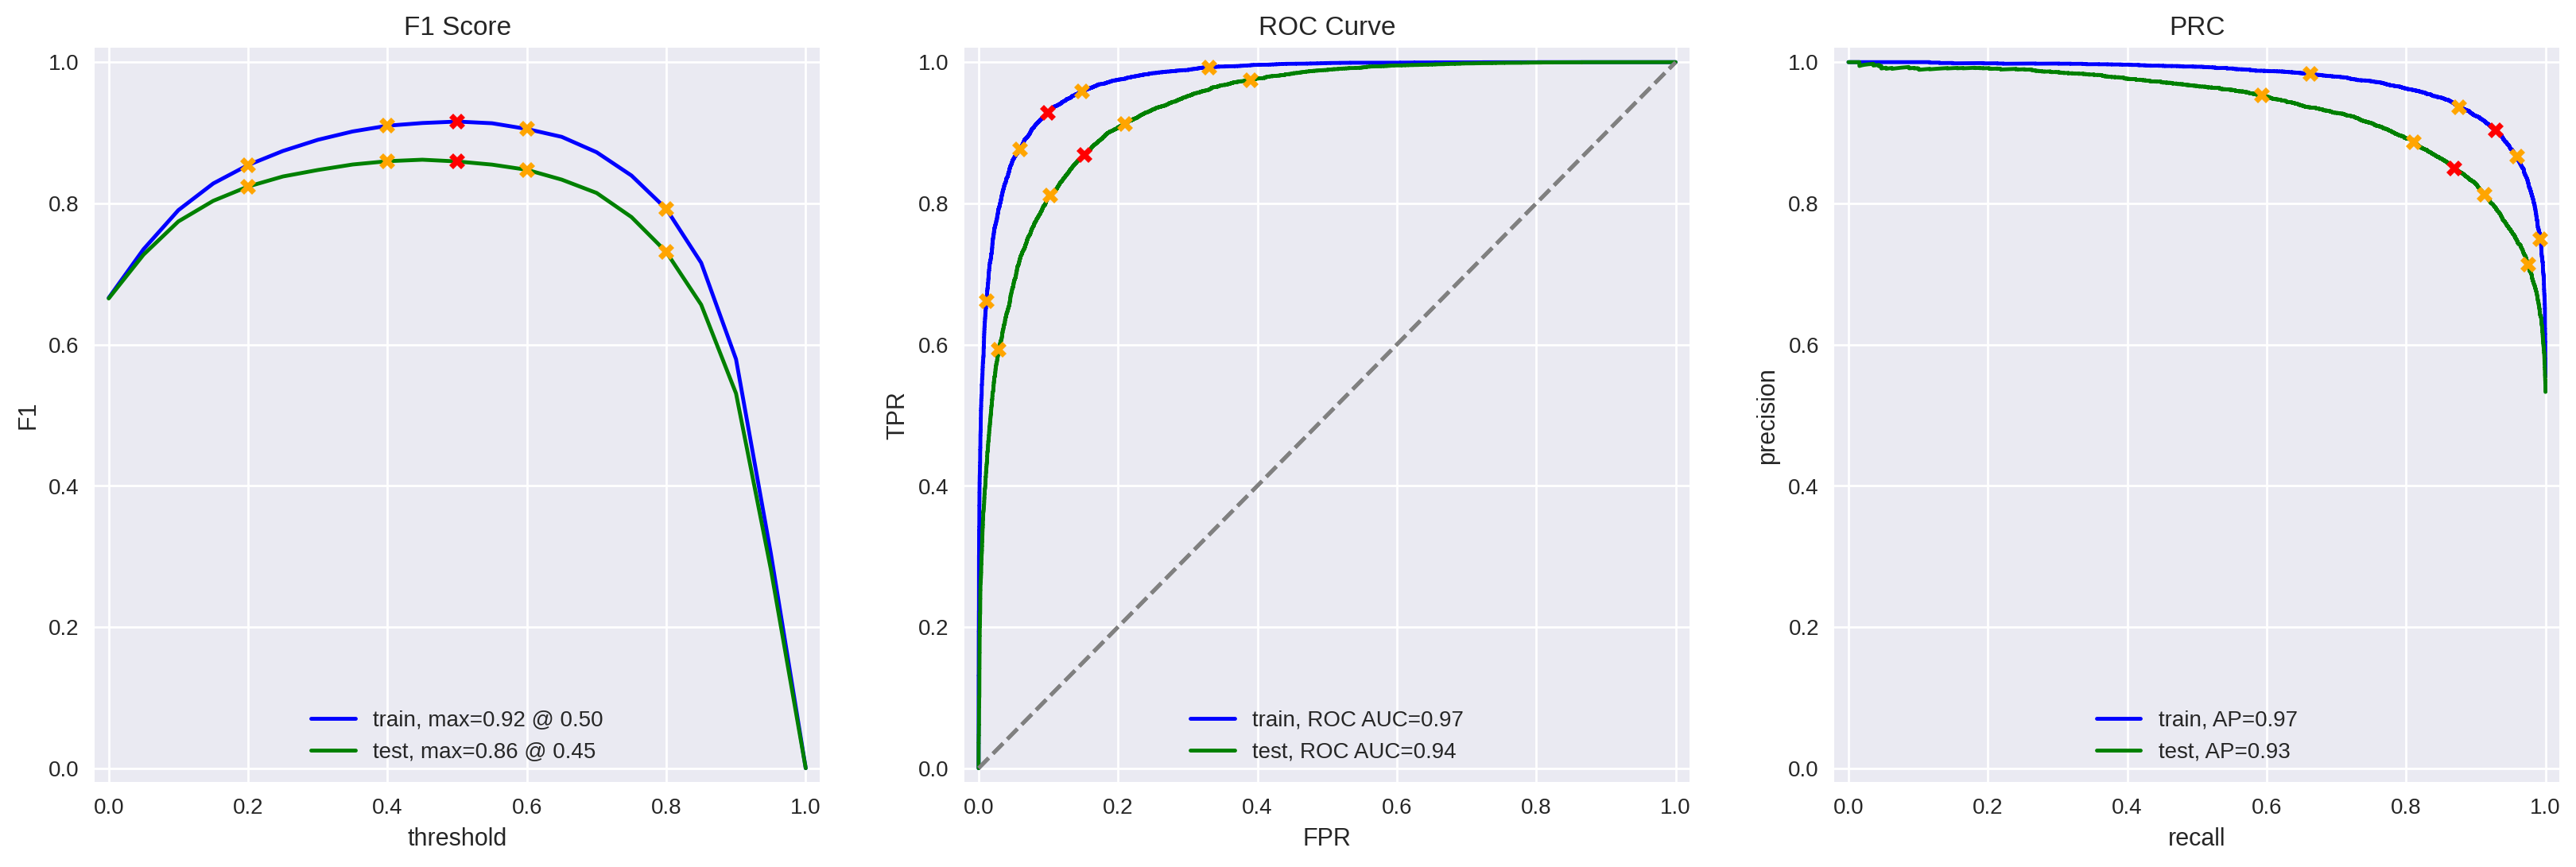

In [27]:
# Evaluate Model
evaluate_model(model_2, train_features_2, y_train, test_features_2, y_test)

<div class="alert alert-warning">
<b>Reviewer's comment V1</b>

Correct. But since the data for model 1 and for model 2 are absolutely the same, it's not necessary to create 2 different TfidfVectorizer. You can use only one and transform the data only once.

</div>

### Model 3 - spaCy, TF-IDF and LR

In [28]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [29]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [30]:
# Apply preprocessing to the dataset
X_train_spacy = X_train.apply(text_preprocessing_3)
X_test_spacy = X_test.apply(text_preprocessing_3)

# TF-IDF Vectorization
tfidf_vectorizer_3 = TfidfVectorizer(max_features=10000)
train_features_3 = tfidf_vectorizer_3.fit_transform(X_train_spacy)
test_features_3 = tfidf_vectorizer_3.transform(X_test_spacy)

# Train Logistic Regression Model
model_3 = LogisticRegression(max_iter=500)
model_3.fit(train_features_3, y_train)

LogisticRegression(max_iter=500)

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.98  0.95
ROC AUC    0.97  0.95


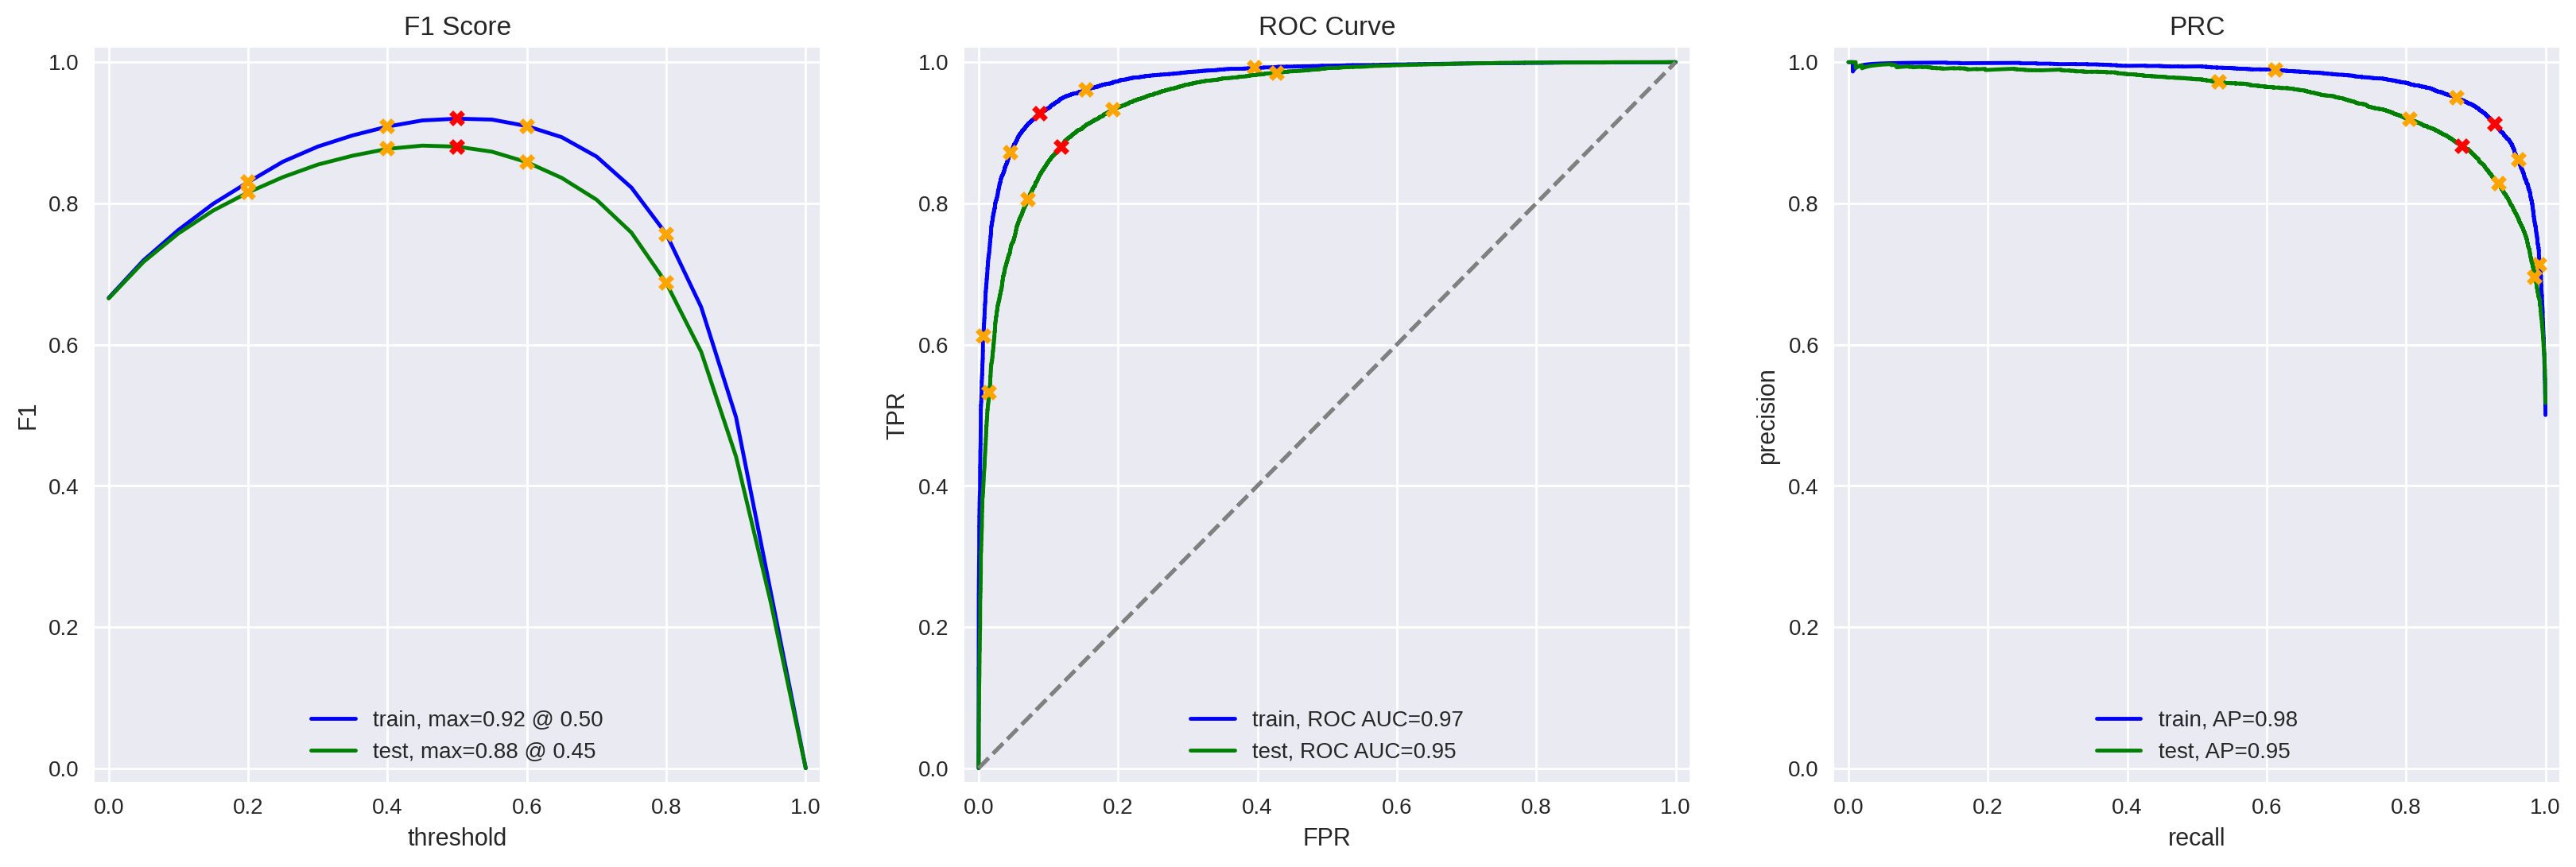

In [31]:
# Evaluate Model
evaluate_model(model_3, train_features_3, y_train, test_features_3, y_test)

<div class="alert alert-warning">
<b>Reviewer's comment V1</b>

Correct. But it's proper to use stop words from models 1 and 2 here to be able to check how only lemmatization affects on model quality.

</div>

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [32]:
# Define text preprocessing function using spaCy
def text_preprocessing_4(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]  # Lemmatization
    return " ".join(tokens)


In [33]:
# Apply preprocessing to the dataset
X_train_spacy_4 = X_train.apply(text_preprocessing_4)
X_test_spacy_4 = X_test.apply(text_preprocessing_4)

# TF-IDF Vectorization
tfidf_vectorizer_4 = TfidfVectorizer(max_features=10000)
train_features_4 = tfidf_vectorizer_4.fit_transform(X_train_spacy_4)
test_features_4 = tfidf_vectorizer_4.transform(X_test_spacy_4)

# Train LightGBM Classifier
model_4 = LGBMClassifier(n_estimators=100, learning_rate=0.1)
model_4.fit(train_features_4, y_train)

LGBMClassifier()

In [34]:
# Check dataset shapes
print("Train Data Shape:", X_train_spacy_4.shape)
print("TF-IDF Features Shape:", train_features_4.shape)
print("Target Shape:", y_train.shape)

Train Data Shape: (23796,)
TF-IDF Features Shape: (23796, 10000)
Target Shape: (23796,)


          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.93
ROC AUC    0.98  0.94


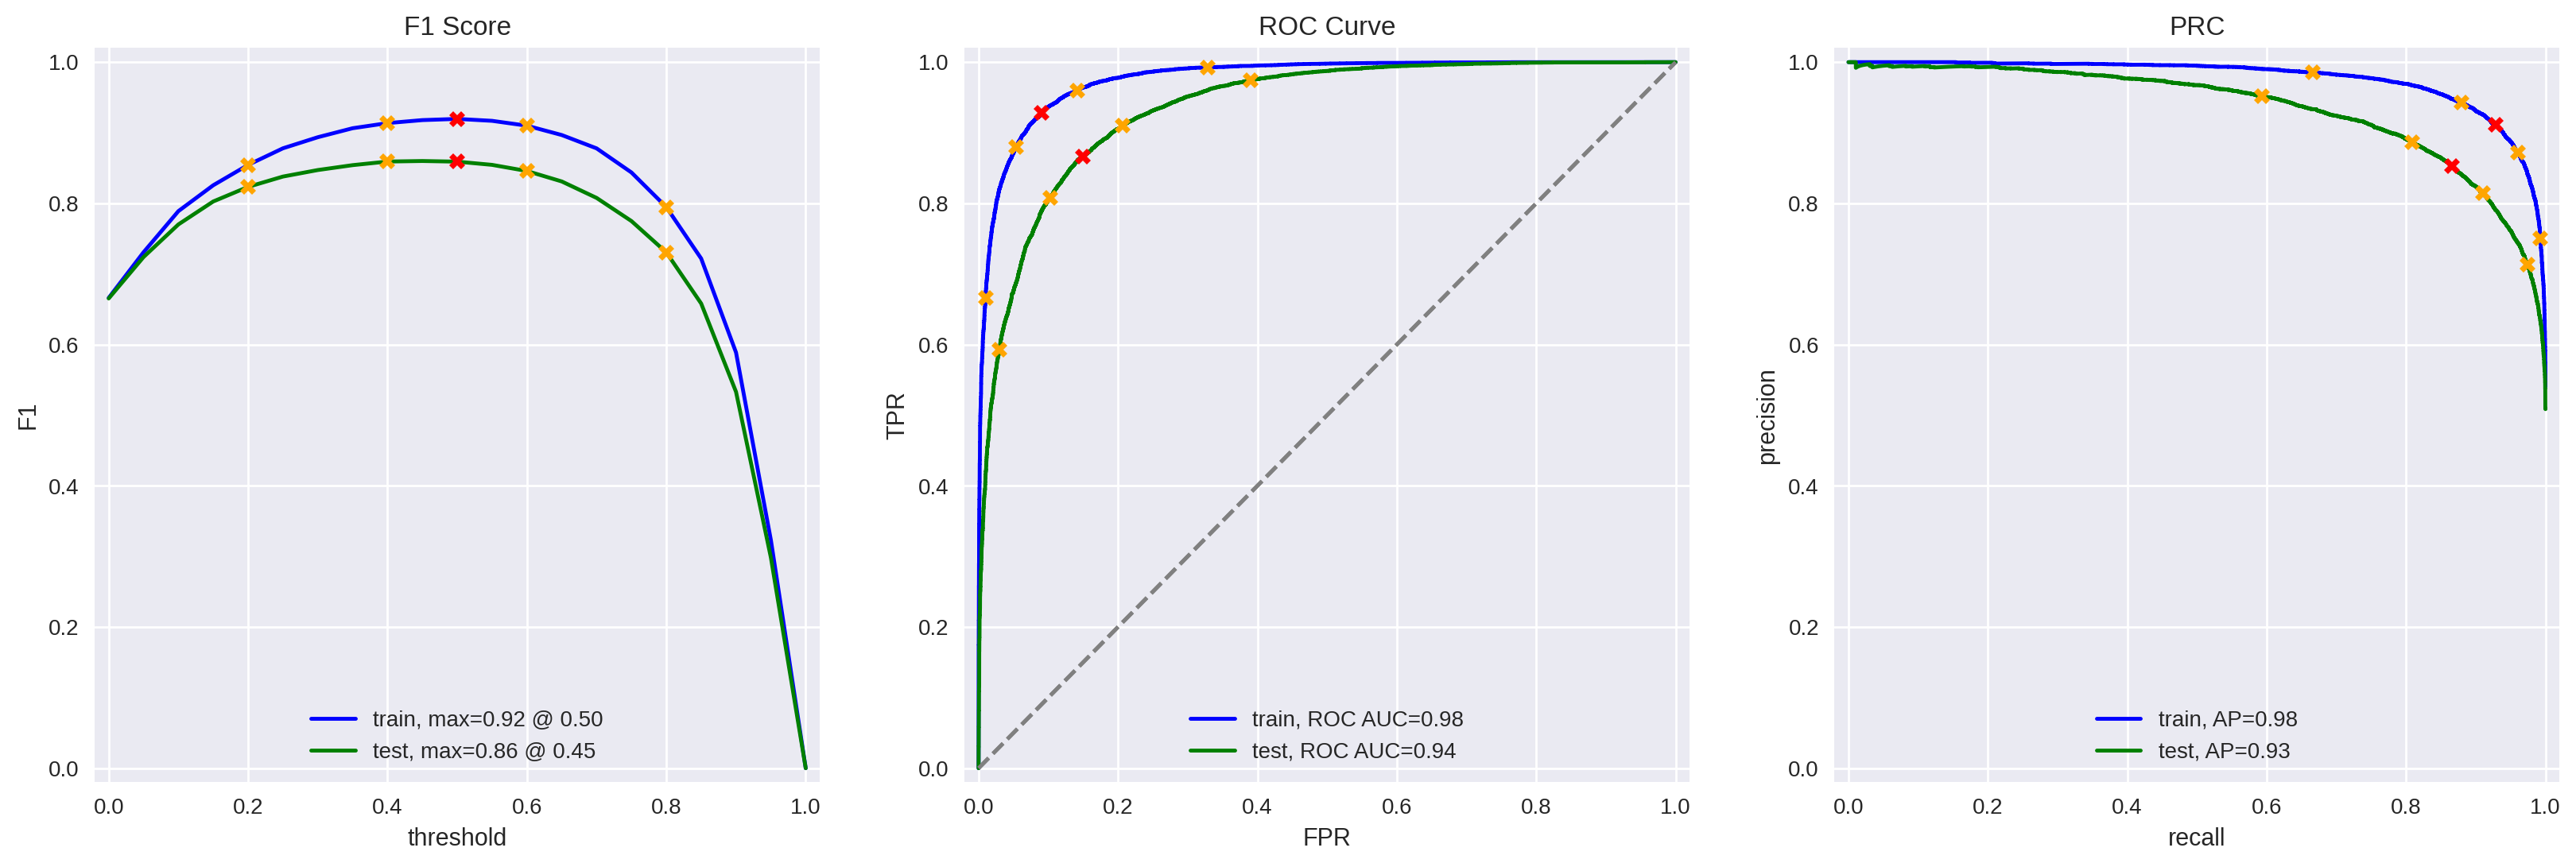

In [35]:
# Evaluate Model
evaluate_model(model_4, train_features_4, y_train, test_features_4, y_test)

<div class="alert alert-warning">
<b>Reviewer's comment V1</b>

Correct. But:

1. It's proper to use stop words from models 1 and 2 here to be able to check how only lemmatization affects on model quality.
2. Since the data for model 3 and for model 4 are absolutely the same, it's not necessary to create 2 different TfidfVectorizer. You can use only one and transform the data only once.
3. Functions text_preprocessing_3 and text_preprocessing_4 are absolutely the same. It means it doesn't make sense to have both.

</div>

## My Reviews

In [36]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text) # <put here the same normalization logic as for the main dataset>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [37]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.63:  i did not simply like it not my kind of movie
0.51:  well i was bored and felt asleep in the middle of the movie
0.65:  i was really fascinated with the movie
0.32:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.60:  i didnt expect the reboot to be so good writers really cared about the source material
0.63:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.18:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.68:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [38]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.18:  i did not simply like it not my kind of movie
0.21:  well i was bored and felt asleep in the middle of the movie
0.52:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.15:  i didnt expect the reboot to be so good writers really cared about the source material
0.68:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [39]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.48:  i did not simply like it not my kind of movie
0.44:  well i was bored and felt asleep in the middle of the movie
0.67:  i was really fascinated with the movie
0.60:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.40:  i didnt expect the reboot to be so good writers really cared about the source material
0.73:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.21:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.80:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Great work!

</div>

## Conclusions

After evaluating four different models, it is evident that Model 1 (NLTK + TF-IDF + Logistic Regression) and Model 3 (spaCy + TF-IDF + Logistic Regression) provide the best performance. Both models achieved an F1-score of 0.88 and a test accuracy of 88%, indicating strong predictive capabilities. Additionally, their ROC-AUC score of 0.95 suggests they are highly effective at distinguishing between positive and negative reviews. Furthermore, these models exhibit minimal overfitting, as their training and test scores remain close, demonstrating their ability to generalize well to unseen data.

In contrast, Model 2 (NLTK + TF-IDF + LGBMClassifier) and Model 4 (spaCy + TF-IDF + LGBMClassifier) performed slightly worse, with an F1-score of 0.86 and a test accuracy of 86%. While still relatively strong, these models did not outperform Logistic Regression, and their ROC-AUC scores of 0.94 indicate a slightly weaker ability to rank positive and negative reviews with confidence. This suggests that LightGBM may require additional hyperparameter tuning, such as increasing the number of estimators or adjusting the learning rate, to match the effectiveness of Logistic Regression.

Based on these results, Model 1 (NLTK + TF-IDF + Logistic Regression) is the recommended choice due to its simplicity, efficiency, and top-tier performance. If additional linguistic processing, such as lemmatization, is required, then Model 3 (spaCy + TF-IDF + Logistic Regression) is a strong alternative. Although the LGBM models showed competitive performance, further fine-tuning would be necessary to justify their use over the more straightforward and highly effective Logistic Regression models.

After testing the models on custom 'my reviews', I've observed some key differences in how each model handled sentiment classification. Overall, all four models were able to distinguish between positive and negative reviews, but some showed greater confidence and accuracy than others. Model 3 is the most confident in extreme sentiment cases. It assigned very low scores to negative reviews and high scores to positive ones, showing a clearer separation of sentiment classes. 

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

You did a great job! Everything is correct except several minor issues I commented above.

</div>

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions